In [1]:
using_colab = False

if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p videos
    !wget -P videos https://dl.fbaipublicfiles.com/segment_anything_2/assets/bedroom.zip
    !unzip -d videos videos/bedroom.zip

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

## Set-up

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [3]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cpu


### Loading the SAM 2 video predictor

In [4]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = r"D:\Kites_projects\Cataract_instrument_segmentation\sam2\checkpoints\sam2.1_hiera_tiny.pt"
model_cfg = r"D:\Kites_projects\Cataract_instrument_segmentation\sam2\sam2\configs\sam2.1\sam2.1_hiera_t.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [5]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

#### Select an example video

We assume that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`.

For your custom videos, you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from `00000.jpg`.

In [6]:
# instrument list: Fixation Ring, MVR Blade, BSS Cannula, OVD Cannula, 

In [7]:
# TIMESTAMPS = [
#         ("00:56", "01:13", "1_Mendez_ring_n_Tryphan_Pen"),
#         ("02:31", "02:42", "2_15_Side_Port_Blade"),
#         ("03:03", "03:26", "3_MVR_Blade_and_Conjunctiva_Forceps"),
#         ("03:46", "04:00", "4_OVD_Cannula"),
#         ("04:07", "04:22", "5_Trypan_Blue_Cannula"),
#         ("04:48", "04:58", "6_BSS_Cannula"),
#         ("05:02", "06:00", "7_OVD_Cannula"),
#         ("06:40", "07:28", "8_Utrata_Forceps"),
#         ("08:14", "08:27", "9_BSS_Cannula"),
#         ("08:36", "11:55", "10_Phacoemulsification_Probe"),
#         ("12:00", "16:40", "11_Phacoemulsification_Probe_and_Sinskey_Hook"),
#         ("17:20", "19:50", "12_Phacoemulsification_Probe"),
#         ("19:58", "20:16", "13_OVD_Cannula"),
#         ("20:20", "20:30", "14_Lens_Cartridge"),
#         ("20:50", "21:18", "15_Kellman_Forceps_and_Lens_Cartridge"),
#         ("21:25", "21:33", "16_Sinskey_Hook"),
#         ("21:45", "22:45", "17_Phacoemulsification_Probe"),
#         ("22:50", "23:40", "18_Phacoemulsification_Probe_and_Sinskey_Hook"),
#         ("24:00", "24:39", "19_BSS_Cannula"),
#     ]

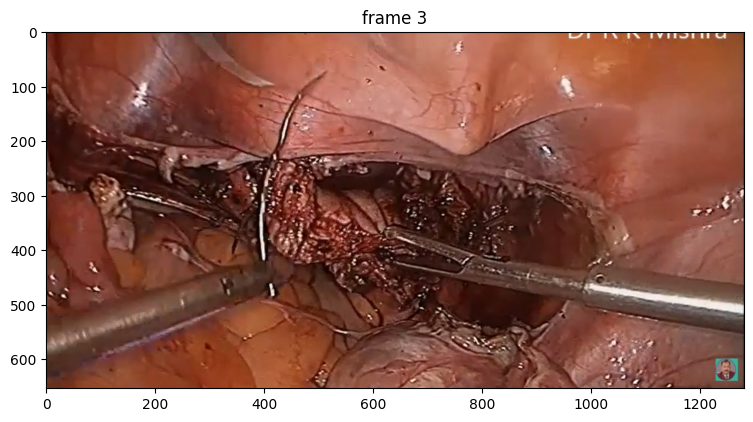

In [8]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = r"D:\Kites_projects\Cataract_instrument_segmentation\sam2\notebooks\videos\cataract\Laparascopy frames"

frame_idx = 3

ann_obj_id_A = 0
ann_obj_id_B = 0
ann_obj_id_c = 3 # use this ID for passing input points on multiple frames, if needed.
ann_obj_id_d = 4

custom_labels = {
    1: "A",
    2: "B",
    3: "C",
    4: "D"

    # Anatomy
    # 1: "Pupil",
    # 2: "Iris",

    # # Instrument
    # 3: "Mendez ring",
    # 4: "Tryphan Pen",
    # 5: "15° Side Port Blade",
    # 6: "MVR Blade", 
    # 7: "Conjunctiva Forceps",
    # 8: "Hydro Cannula",
    # 9: "Trypan Blue Cannula",
    # 10: "BSS Cannula",
    # 11: "Utrata Forceps",
    # 12: "Phacoemulsification Probe",
    # 13: "Chopper",
    # 14: "Lens Cartridge",
    # 15: "Machtorphoihe",
    # 16: "Sinskey Hook",

    #7: "Kellman Forceps",
    #12: "Fixation Ring",
    #13: "Keratome",
    #14: "OVD Cannula",
    #16: "Other Tool",
    #17: "lens",
}

#print(len(custom_labels))

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG", ".png"]
]

frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [9]:
#stop and adjust

#### Initialize the inference state

SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [10]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 8/8 [00:00<00:00, 20.79it/s]


### Example 3: Segment multiple objects simultaneously

Note: if you have run any previous tracking using this `inference_state`, please reset it first via `reset_state`.

In [11]:
predictor.reset_state(inference_state)

#### Step 1: Add two objects on a frame

SAM 2 can also segment and track two or more objects at the same time. One way, of course, is to do them one by one. However, it would be more efficient to batch them together (e.g. so that we can share the image features between objects to reduce computation costs).

This time, let's focus on object parts and segment **the shirts of both childen** in this video. Here we add prompts for these two objects and assign each of them a unique object id.

In [12]:
prompts = {}  # hold all the clicks we add for visualization

Add the first object (the left child's shirt) with a **positive click** at (x, y) = (200, 300) on frame 0.

We assign it to object id `2` (it can be arbitrary integers, and only needs to be unique for each object to track), which is passed to the `add_new_points_or_box` API to distinguish the object we are clicking upon.

### Interactive annotator

In [13]:
import cv2
import numpy as np
from PIL import Image

class InteractiveAnnotatorWithSAM:
    def __init__(self, frame_path, predictor=None, inference_state=None, frame_idx=None, obj_id=None):
        self.frame_path = frame_path
        self.predictor = predictor
        self.inference_state = inference_state
        self.frame_idx = frame_idx
        self.obj_id = obj_id
        
        self.points = []
        self.labels = []
        self.img = None
        self.display_img = None
        self.current_mask = None
        self.window_name = "Interactive SAM Annotation"
        self.sam_result = None
        
    def mouse_callback(self, event, x, y, flags, param):
        """Handle mouse events"""
        if event == cv2.EVENT_LBUTTONDOWN:  # Left click - add positive point
            self.add_point(x, y, 1)
            
        elif event == cv2.EVENT_RBUTTONDOWN:  # Right click - add negative point
            self.add_point(x, y, 0)
            
    def add_point(self, x, y, label):
        """Add a point and update display"""
        self.points.append([x, y])
        self.labels.append(label)
        
        point_type = "positive" if label == 1 else "negative"
        print(f"Added {point_type} point at ({x}, {y})")
        
        # Update display
        self.update_display()
        
    def run_sam_prediction(self):
        """Run SAM2 prediction and get mask"""
        if len(self.points) == 0 or self.predictor is None:
            print("No points or predictor not available")
            return None
            
        points_array = np.array(self.points, dtype=np.float32)
        labels_array = np.array(self.labels, dtype=np.int32)
        
        try:
            # Run SAM2 prediction
            _, out_obj_ids, out_mask_logits = self.predictor.add_new_points_or_box(
                inference_state=self.inference_state,
                frame_idx=self.frame_idx,
                obj_id=self.obj_id,
                points=points_array,
                labels=labels_array,
            )
            
            # Get mask
            # mask = (out_mask_logits[0] > 0.0).cpu().numpy()
            # Find which index corresponds to our current object ID
            mask_idx = out_obj_ids.index(self.obj_id)
            mask = (out_mask_logits[mask_idx] > 0.0).cpu().numpy()
            self.current_mask = mask
            
            # Store result
            self.sam_result = (points_array, labels_array, out_obj_ids, out_mask_logits)
            
            print("SAM prediction completed - mask overlay updated")
            return mask
            
        except Exception as e:
            print(f"SAM prediction error: {e}")
            return None
            
    def update_display(self):
        """Update the display with points and mask overlay"""
        # Start with original image
        self.display_img = self.img.copy()
        
        # # Apply mask overlay if available
        # if self.current_mask is not None:
        #     # Create colored mask overlay (green with transparency)
        #     mask_colored = np.zeros_like(self.display_img)
        #     mask_colored[:, :, 1] = 255  # Green channel
            
        #     # Apply mask with transparency
        #     alpha = 0.4  # Transparency level
        #     mask_area = self.current_mask.squeeze()
            
        #     # Blend mask with original image
        #     for c in range(3):
        #         self.display_img[:, :, c] = np.where(
        #             mask_area,
        #             self.display_img[:, :, c] * (1 - alpha) + mask_colored[:, :, c] * alpha,
        #             self.display_img[:, :, c]
        #         )
        
        if self.current_mask is not None:
            # Create colored mask overlay (green with transparency)
            mask_colored = np.zeros_like(self.display_img)
            mask_colored[:, :, 1] = 255  # Green channel

            # Resize mask to match display image size if needed
            mask_area = self.current_mask.squeeze()
            h_img, w_img = self.display_img.shape[:2]
            h_mask, w_mask = mask_area.shape[:2]

            if (h_mask != h_img) or (w_mask != w_img):
                mask_area = cv2.resize(mask_area.astype(np.uint8), (w_img, h_img), interpolation=cv2.INTER_NEAREST)
                mask_area = mask_area.astype(bool)
                print(f"[Warning] Mask resized from ({h_mask}, {w_mask}) to ({h_img}, {w_img})")

            # Blend mask with transparency
            alpha = 0.4
            for c in range(3):
                self.display_img[:, :, c] = np.where(
                    mask_area,
                    self.display_img[:, :, c] * (1 - alpha) + mask_colored[:, :, c] * alpha,
                    self.display_img[:, :, c]
                )




        # Draw points on top
        for i, (point, label) in enumerate(zip(self.points, self.labels)):
            x, y = int(point[0]), int(point[1])
            color = (0, 255, 0) if label == 1 else (0, 0, 255)  # Green for positive, Red for negative
            cv2.circle(self.display_img, (x, y), 8, color, -1)
            cv2.circle(self.display_img, (x, y), 10, (255, 255, 255), 2)  # White border
            
        # # Add instructions text
        # instructions = [
        #     "Left click: Positive point (green)",
        #     "Right click: Negative point (red)",
        #     "Press 'p': Preview SAM mask overlay",
        #     "Press 'c': Clear all points and mask",
        #     "Press 's': Submit final result",
        #     "Press 'q': Quit"
        # ]
        
        # y_offset = 30
        # for text in instructions:
        #     cv2.putText(self.display_img, text, (10, y_offset), 
        #                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        #     cv2.putText(self.display_img, text, (10, y_offset), 
        #                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)  # Black outline
        #     y_offset += 25
            
        # Show point count and mask status
        # status_text = f"Points: {len(self.points)}"
        status_text = f"Points: {len(self.points)} | Obj ID: {self.obj_id}"
        if self.current_mask is not None:
            status_text += " | Mask: ON"
        cv2.putText(self.display_img, status_text, (10, self.display_img.shape[0] - 20), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
        
        # Add this line after the existing cv2.putText for status_text
        cv2.putText(self.display_img, f"Object ID: {self.obj_id}", (10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
            
        cv2.imshow(self.window_name, self.display_img)
        
    def start_annotation(self):
        """Start the interactive annotation process"""
        # Load image
        if self.frame_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            self.img = cv2.imread(self.frame_path)
        else:
            pil_img = Image.open(self.frame_path)
            self.img = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
            
        if self.img is None:
            print(f"Error: Could not load image from {self.frame_path}")
            return None, None, None, None
            
        # Create window and set mouse callback
        cv2.namedWindow(self.window_name, cv2.WINDOW_NORMAL)
        cv2.resizeWindow(self.window_name, 1200, 800)
        cv2.setMouseCallback(self.window_name, self.mouse_callback)
        
        print(f"\nInteractive SAM Annotation Started")
        print(f"Frame: {self.frame_idx}, Object ID: {self.obj_id}")
        print("Click on the object, press 'V' to Visualization, 'S' to Submit, 'right click' to add positive point, 'left click' to add negative point")
        
        # Initial display
        self.update_display()
        
        # Main loop
        while True:
            key = cv2.waitKey(1) & 0xFF
            
            if key == ord('v'):  # Preview SAM result
                if len(self.points) > 0:
                    print("Running SAM2 prediction...")
                    mask = self.run_sam_prediction()
                    if mask is not None:
                        self.update_display()
                    else:
                        print("SAM prediction failed")
                else:
                    print("Add some points first!")
                    
            elif key == ord('s'):  # Submit
                if len(self.points) > 0:
                    if self.current_mask is None:
                        print("Running final SAM2 prediction...")
                        self.run_sam_prediction()
                    
                    if self.sam_result:
                        print(f"Submitted {len(self.points)} points with SAM2 result")
                        break
                    else:
                        print("SAM prediction failed - try different points")
                else:
                    print("No points to submit! Add some points first.")
                    
            elif key == ord('c'):  # Clear
                self.clear_all()
                
            elif key == ord('q'):  # Quit
                print("Annotation cancelled")
                cv2.destroyAllWindows()
                return None, None, None, None
                
        cv2.destroyAllWindows()
        
        if self.sam_result:
            points, labels, out_obj_ids, out_mask_logits = self.sam_result
            return points, labels, out_obj_ids, out_mask_logits
        else:
            return None, None, None, None
            
    def clear_all(self):
        """Clear all points and mask"""
        self.points = []
        self.labels = []
        self.current_mask = None
        self.sam_result = None
        self.update_display()
        print("Cleared all points and mask")

def annotate_with_realtime_sam(video_dir, frame_names, frame_idx, obj_id, 
                              predictor, inference_state):
    """Interactive annotation with real-time SAM2 visualization in same window"""
    import os
    frame_path = os.path.join(video_dir, frame_names[frame_idx])
    
    annotator = InteractiveAnnotatorWithSAM(
        frame_path=frame_path,
        predictor=predictor,
        inference_state=inference_state,
        frame_idx=frame_idx,
        obj_id=obj_id
    )
    
    return annotator.start_annotation()

In [14]:
if (ann_obj_id_A != 0):
    ann_frame_idx_A = frame_idx
    #ann_obj_id_A = 1

    points_A, labels_A, out_obj_ids, out_mask_logits = annotate_with_realtime_sam(
        video_dir, frame_names, ann_frame_idx_A, ann_obj_id_A, 
        predictor, inference_state
    )

    if points_A is not None:
        prompts[ann_obj_id_A] = points_A, labels_A
        print("Object A annotation complete!")

    plt.figure(figsize=(9, 6))
    plt.title(f"Object A at frame {ann_frame_idx_A}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx_A])))
    show_points(points_A, labels_A, plt.gca())
    for i, out_obj_id in enumerate(out_obj_ids):
        if out_obj_id == ann_obj_id_A:  # Only show Object A
            show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

else:
    pass        

In [15]:
if (ann_obj_id_B != 0):

    ann_frame_idx_B = frame_idx

    points_B, labels_B, out_obj_ids, out_mask_logits = annotate_with_realtime_sam(
        video_dir, frame_names, ann_frame_idx_B, ann_obj_id_B, 
        predictor, inference_state
    )

    if points_B is not None:
        prompts[ann_obj_id_B] = points_B, labels_B
        print("Object A annotation complete!")

    plt.figure(figsize=(9, 6))
    plt.title(f"Object B at frame {ann_frame_idx_B}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx_B])))
    show_points(points_B, labels_B, plt.gca())
    for i, out_obj_id in enumerate(out_obj_ids):
        if out_obj_id == ann_obj_id_B:  # Only show Object B
            show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)
            
else:
    pass


Interactive SAM Annotation Started
Frame: 3, Object ID: 3
Click on the object, press 'V' to Visualization, 'S' to Submit, 'right click' to add positive point, 'left click' to add negative point
Added positive point at (104, 545)
Running SAM2 prediction...


D:\Kites_projects\Cataract_instrument_segmentation\sam2\sam2\sam2_video_predictor.py:902: UserWarning: cannot import name '_C' from 'sam2' (D:\Kites_projects\Cataract_instrument_segmentation\sam2\sam2\__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


SAM prediction completed - mask overlay updated
[Warning] Mask resized from (674, 1280) to (654, 1280)
Added positive point at (395, 403)
[Warning] Mask resized from (674, 1280) to (654, 1280)
Running SAM2 prediction...
SAM prediction completed - mask overlay updated
[Warning] Mask resized from (674, 1280) to (654, 1280)
Added positive point at (449, 143)
[Warning] Mask resized from (674, 1280) to (654, 1280)
Running SAM2 prediction...
SAM prediction completed - mask overlay updated
[Warning] Mask resized from (674, 1280) to (654, 1280)
Added negative point at (353, 379)
[Warning] Mask resized from (674, 1280) to (654, 1280)
Running SAM2 prediction...
SAM prediction completed - mask overlay updated
[Warning] Mask resized from (674, 1280) to (654, 1280)
Added positive point at (394, 466)
[Warning] Mask resized from (674, 1280) to (654, 1280)
Running SAM2 prediction...
SAM prediction completed - mask overlay updated
[Warning] Mask resized from (674, 1280) to (654, 1280)
Added positive po

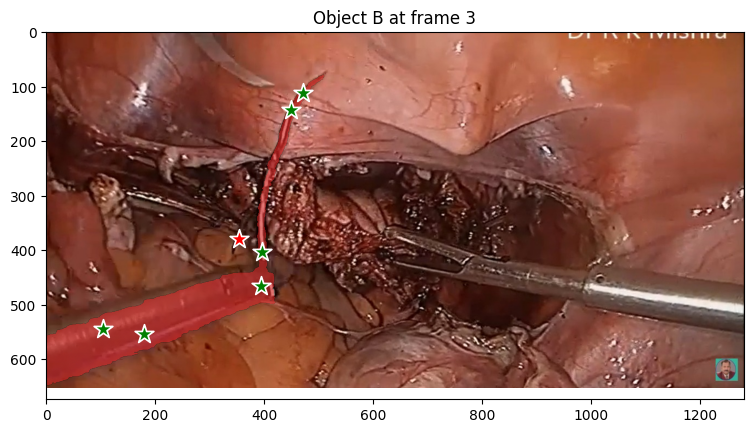

In [16]:
if (ann_obj_id_c != 0):
    ann_frame_idx_c = frame_idx #frame_idx

    points_c, labels_c, out_obj_ids, out_mask_logits = annotate_with_realtime_sam(
        video_dir, frame_names, ann_frame_idx_c, ann_obj_id_c, 
        predictor, inference_state
    )

    if points_c is not None:
        prompts[ann_obj_id_c] = points_c, labels_c
        print("Object A annotation complete!")

    plt.figure(figsize=(9, 6))
    plt.title(f"Object B at frame {ann_frame_idx_c}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx_c])))
    show_points(points_c, labels_c, plt.gca())
    for i, out_obj_id in enumerate(out_obj_ids):
        if out_obj_id == ann_obj_id_c:  # Only show Object B
            show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

else:
    pass


Interactive SAM Annotation Started
Frame: 3, Object ID: 4
Click on the object, press 'V' to Visualization, 'S' to Submit, 'right click' to add positive point, 'left click' to add negative point
Added positive point at (707, 394)
Running SAM2 prediction...
SAM prediction completed - mask overlay updated
[Warning] Mask resized from (674, 1280) to (654, 1280)
Added positive point at (829, 421)
[Warning] Mask resized from (674, 1280) to (654, 1280)
Running SAM2 prediction...
SAM prediction completed - mask overlay updated
[Warning] Mask resized from (674, 1280) to (654, 1280)
Added negative point at (828, 421)
[Warning] Mask resized from (674, 1280) to (654, 1280)
Cleared all points and mask
Added positive point at (676, 377)
Running SAM2 prediction...
SAM prediction completed - mask overlay updated
[Warning] Mask resized from (674, 1280) to (654, 1280)
Cleared all points and mask
Added positive point at (866, 445)
Cleared all points and mask
Cleared all points and mask
Added positive poi

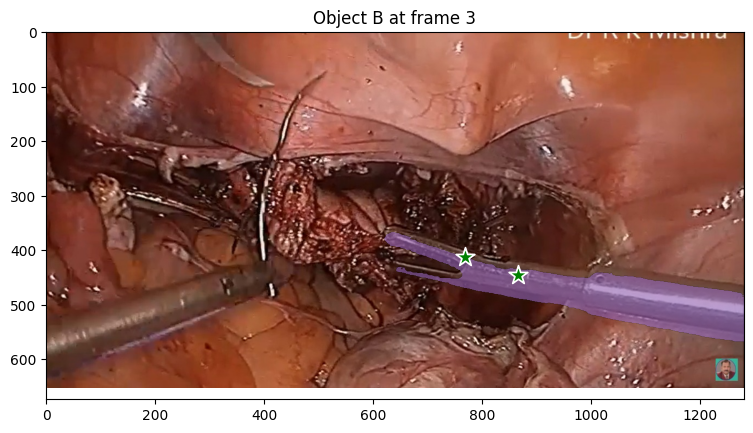

In [17]:
if (ann_obj_id_d != 0):
    ann_frame_idx_d = frame_idx

    points_d, labels_d, out_obj_ids, out_mask_logits = annotate_with_realtime_sam(
        video_dir, frame_names, ann_frame_idx_d, ann_obj_id_d, 
        predictor, inference_state
    )

    if points_d is not None:
        prompts[ann_obj_id_d] = points_d, labels_d
        print("Object A annotation complete!")

    plt.figure(figsize=(9, 6))
    plt.title(f"Object B at frame {ann_frame_idx_d}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx_d])))
    show_points(points_d, labels_d, plt.gca())
    for i, out_obj_id in enumerate(out_obj_ids):
        if out_obj_id == ann_obj_id_d:  # Only show Object B
            show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

else:
    pass

In [18]:
# Now propagate the segmentation to track both objects throughout the video
print("Propagating segmentations throughout the video...")
tracked_frames = []
tracked_masks = []

for frame_idx, obj_ids, mask_logits in predictor.propagate_in_video(inference_state=inference_state):
    # Store results for later visualization
    tracked_frames.append(frame_idx)
    tracked_masks.append(mask_logits.cpu())
    
    # Optional: Print progress
    if frame_idx % 10 == 0:
        print(f"Processed frame {frame_idx}")

print("Propagation complete!")

# Visualize the results at different points in the video
# We'll visualize frames 0, 10, 15, and 20 to see the appearance/disappearance

display_frames = [ann_frame_idx_A+1]  # Adjust based on your video
plt.figure(figsize=(16, 12))

for i, frame_idx in enumerate(display_frames):
    # Find this frame in our tracked results
    result_idx = tracked_frames.index(frame_idx)
    mask_logits = tracked_masks[result_idx]
    
    plt.subplot(2, 2, i+1)
    plt.title(f"Frame {frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))
    
    # Show all tracked objects in this frame
    for j, obj_id in enumerate(obj_ids):
        # Check if the object has a meaningful mask in this frame
        # A simple heuristic: if any pixel is above threshold, consider the object present
        mask = (mask_logits[j] > 0.0).numpy()
        if np.any(mask):
            # If this is one of the frames with clicks, show the points
            if (obj_id == ann_obj_id_A and frame_idx == ann_frame_idx_A):
            #    (obj_id == ann_obj_id_B and frame_idx == ann_frame_idx_B) or \
            #    (obj_id == ann_obj_id_C and frame_idx == ann_frame_idx_C):
                show_points(*prompts[obj_id], plt.gca())
                
            # Show the mask with appropriate object ID for color
            show_mask(mask, plt.gca(), obj_id=obj_id)
            
            # Add a label to indicate which object this is
            plt.text(10, 30 + j*20, f"Object {obj_id}", 
                     color='white', fontsize=10, bbox=dict(facecolor='black', alpha=0.5))

plt.tight_layout()
plt.show()

Propagating segmentations throughout the video...


propagate in video: 100%|██████████| 5/5 [00:24<00:00,  4.81s/it]


Propagation complete!


NameError: name 'ann_frame_idx_A' is not defined

In [19]:
import os
import cv2
import numpy as np
import json
from matplotlib import pyplot as plt
from PIL import Image
from datetime import datetime

# Create an output directory structure
video_name = os.path.basename(video_dir)
output_dir = os.path.join(os.path.dirname(video_dir), "Output_with_Anotomy", video_name)
os.makedirs(output_dir, exist_ok=True)

# Create sub-folders for different outputs
input_images_dir = os.path.join(output_dir, "input_images")
segment_mask_dir = os.path.join(output_dir, "segment_mask")
overlay_dir = os.path.join(output_dir, "mask_overlay")
coco_dir = os.path.join(output_dir, "coco_json")

# Create all directories
for directory in [input_images_dir, segment_mask_dir, overlay_dir, coco_dir]:
    os.makedirs(directory, exist_ok=True)

# Define a function to create color-coded masks
def create_color_mask(masks, obj_ids):
    """
    Create a color-coded mask with different objects in different colors
    Args:
        masks: A list of binary masks, one per object
        obj_ids: A list of object IDs for color assignment
    Returns:
        A color-coded mask image with alpha channel
    """
    # Check if masks is empty
    if not masks or len(masks) == 0:
        return None
    
    # Print mask shape to debug
    print(f"Mask shape: {masks[0].shape}")
    
    # Define color map - get a range of distinct colors
    colormap = plt.cm.get_cmap('tab10')  # 10 distinct colors
    
    # Initialize the colored mask
    mask_shape = masks[0].shape
    
    # Handle different possible mask shapes properly
    if len(mask_shape) == 2:
        h, w = mask_shape
    elif len(mask_shape) == 3:
        if mask_shape[0] == 1:  # Shape like (1, H, W)
            h, w = mask_shape[1], mask_shape[2]
        else:
            h, w = mask_shape[0], mask_shape[1]
    else:
        print(f"Unexpected mask shape: {mask_shape}")
        return None
    
    colored_mask = np.zeros((h, w, 4), dtype=np.uint8)  # RGBA
    
    for i, mask in enumerate(masks):
        # Ensure mask is 2D
        if len(mask.shape) == 3:
            if mask.shape[0] == 1:  # (1, H, W)
                mask = mask[0]
            else:
                mask = mask[:, :, 0]  # Take first channel
                
        if np.any(mask):  # Only process non-empty masks
            # Get a color from the colormap based on object ID
            obj_id = obj_ids[i] if i < len(obj_ids) else i
            color_idx = obj_id % 10  # Wrap around if more than 10 objects
            color = np.array(colormap(color_idx)) * 255
            
            # Create a colored mask for this object
            object_mask = np.zeros((h, w, 4), dtype=np.uint8)
            object_mask[mask > 0, 0] = color[0]  # R
            object_mask[mask > 0, 1] = color[1]  # G
            object_mask[mask > 0, 2] = color[2]  # B
            object_mask[mask > 0, 3] = 180  # Alpha (semi-transparent)
            
            # Combine with the existing colored mask
            colored_mask = np.where(object_mask[:,:,3:4] > 0, object_mask, colored_mask)
    
    return colored_mask


def create_coco_annotation_with_holes(mask_img, obj_id, image_id, annotation_id):
    """
    Create COCO annotation that properly handles holes in objects
    """
    # Find contours with hierarchy to detect holes
    contours, hierarchy = cv2.findContours(mask_img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return None
    
    # Group contours by parent-child relationship
    # hierarchy format: [Next, Previous, First_Child, Parent]
    segmentation_polygons = []
    processed = set()
    
    for i, contour in enumerate(contours):
        if i in processed:
            continue
            
        # Skip tiny contours
        if contour.shape[0] < 3:
            continue
            
        # Check if this is an outer contour (parent = -1)
        if hierarchy[0][i][3] == -1:  # This is an outer contour
            # Add the outer contour
            outer_poly = contour.flatten().tolist()
            if len(outer_poly) >= 6:  # At least 3 points (x,y pairs)
                segmentation_polygons.append(outer_poly)
                processed.add(i)
                
                # Look for holes (child contours)
                child_idx = hierarchy[0][i][2]  # First child
                while child_idx != -1:
                    if child_idx < len(contours):
                        hole_contour = contours[child_idx]
                        if hole_contour.shape[0] >= 3:
                            hole_poly = hole_contour.flatten().tolist()
                            if len(hole_poly) >= 6:
                                segmentation_polygons.append(hole_poly)
                        processed.add(child_idx)
                        # Get next sibling hole
                        child_idx = hierarchy[0][child_idx][0]
                    else:
                        break
    
    if not segmentation_polygons:
        return None
    
    # Calculate bounding box and area from the mask
    y_coords, x_coords = np.where(mask_img > 0)
    if len(x_coords) == 0:
        return None
        
    x_min, x_max = int(x_coords.min()), int(x_coords.max())
    y_min, y_max = int(y_coords.min()), int(y_coords.max())
    
    bbox = [x_min, y_min, x_max - x_min + 1, y_max - y_min + 1]
    area = float(np.sum(mask_img > 0))
    
    annotation = {
        "id": annotation_id,
        "image_id": image_id,
        "category_id": int(obj_id),
        "segmentation": segmentation_polygons,
        "area": area,
        "bbox": bbox,
        "iscrowd": 0
    }
    
    return annotation

# Updated processing loop (replace the relevant part in your main code)
def process_frame_with_holes(masks, obj_ids, frame_idx):
    """
    Process frame and create proper COCO annotations with holes
    """
    frame_annotations = []
    annotation_id = 1
    
    for j, mask in enumerate(masks):
        # Ensure mask is 2D
        if len(mask.shape) > 2:
            mask = mask.squeeze()
            
        # Skip empty masks
        if not np.any(mask):
            continue
            
        # Convert to uint8
        mask_img = (mask * 255).astype(np.uint8)
        obj_id = obj_ids[j]
        
        # Create annotation with proper hole handling
        annotation = create_coco_annotation_with_holes(
            mask_img, obj_id, frame_idx, annotation_id
        )
        
        if annotation:
            frame_annotations.append(annotation)
            annotation_id += 1
    
    return frame_annotations

# We'll create individual COCO format JSON files for each frame
annotation_id = 1  # Counter for annotation IDs

print(f"Saving segmented frames and masks...")

for frame_idx, mask_logits in zip(tracked_frames, tracked_masks):
    # Load the original frame
    frame_path = os.path.join(video_dir, frame_names[frame_idx])
    frame = cv2.imread(frame_path)
    if frame is None:
        print(f"Warning: Could not read frame {frame_idx} from {frame_path}")
        continue
        
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    
    # Save original input image to input_images_dir
    input_img_path = os.path.join(input_images_dir, f"frame_{frame_idx:04d}.jpg")
    cv2.imwrite(input_img_path, frame)
    
    # Create COCO format data for this frame
    frame_annotations = []
    
    try:
        # Create binary masks for each object
        masks = []
        for j in range(len(obj_ids)):
            mask = (mask_logits[j] > 0.0).numpy()
            # Ensure mask has correct shape
            if len(mask.shape) > 2:
                mask = mask.squeeze()  # Remove singleton dimensions
            masks.append(mask)
            
            # Skip empty masks
            if not np.any(mask):
                continue
                
            # Save individual mask to segment_mask_dir
            obj_id = obj_ids[j]
            obj_mask_dir = os.path.join(segment_mask_dir, f"object_{obj_id}")
            os.makedirs(obj_mask_dir, exist_ok=True)
            
            mask_img = (mask * 255).astype(np.uint8)
            mask_path = os.path.join(obj_mask_dir, f"frame_{frame_idx:04d}.png")
            cv2.imwrite(mask_path, mask_img)
            
            # Add annotation to COCO format
            # Find contours for RLE or polygon format
            #contours, _ = cv2.findContours(mask_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            annotation = create_coco_annotation_with_holes(mask_img, obj_id, frame_idx, annotation_id)

            # for contour in contours:
            #     # Skip tiny contours
            #     if contour.shape[0] < 3:  # Need at least 3 points for a polygon
            #         continue
                    
            #     # Convert contour to COCO polygon format
            #     segmentation = contour.flatten().tolist()
                
            #     # Calculate bounding box
            #     x, y, w, h = cv2.boundingRect(contour)
                
            #     # Calculate area
            #     area = cv2.contourArea(contour)
                
            #     # Add annotation
            #     annotation = {
            #         "id": annotation_id,
            #         "image_id": frame_idx,
            #         "category_id": int(obj_id),
            #         "segmentation": [segmentation],
            #         "area": float(area),
            #         "bbox": [x, y, w, h],
            #         "iscrowd": 0
            #     }
            if annotation:
                frame_annotations.append(annotation)
                annotation_id += 1
        
        # Create color-coded mask for all objects
        color_mask = create_color_mask(masks, obj_ids)
        if color_mask is None:
            print(f"Warning: No valid masks for frame {frame_idx}")
            continue
        
        # Create mask-only image and save to segment_mask_dir
        combined_mask_path = os.path.join(segment_mask_dir, f"combined_mask_{frame_idx:04d}.png")
        #cv2.imwrite(combined_mask_path, cv2.cvtColor(color_mask, cv2.COLOR_RGBA2BGRA))
        
        # Overlay mask on original frame and save to overlay_dir
        frame_pil = Image.fromarray(frame_rgb)
        mask_pil = Image.fromarray(color_mask.astype('uint8'))
        
        frame_with_mask = frame_pil.copy()
        frame_with_mask.paste(mask_pil, (0, 0), mask_pil)
        
        frame_with_mask_np = np.array(frame_with_mask)
        overlay_path = os.path.join(overlay_dir, f"overlay_{frame_idx:04d}.jpg")
        cv2.imwrite(overlay_path, cv2.cvtColor(frame_with_mask_np, cv2.COLOR_RGB2BGR))
        
        # Print progress periodically
        if frame_idx % 10 == 0:
            print(f"Processed frame {frame_idx}")
            
        # Save COCO JSON file for this frame if we have annotations
        if frame_annotations:
            coco_json_path = os.path.join(coco_dir, f"frame_{frame_idx:04d}.json")
            with open(coco_json_path, 'w') as f:
                json.dump(frame_annotations, f, indent=2)
            
    except Exception as e:
        print(f"Error processing frame {frame_idx}: {e}")
        continue

# We're done processing all frames
print("All processing complete!")
# print(f"- Input images saved to: {input_images_dir}")
# print(f"- Segmentation masks saved to: {segment_mask_dir}")
# print(f"- Overlay images saved to: {overlay_dir}")
# print(f"- COCO format JSON files saved to: {coco_dir}")

Saving segmented frames and masks...
Mask shape: (674, 1280)
Mask shape: (674, 1280)


C:\Users\Admin\AppData\Local\Temp\ipykernel_19380\4140098495.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab10')  # 10 distinct colors


Mask shape: (674, 1280)
Mask shape: (674, 1280)
Mask shape: (674, 1280)
All processing complete!


In [ ]:
kk

NameError: name 'kk' is not defined

### visulaization 

In [ ]:
"""
Professional COCO Annotation Visualizer for Jupyter Notebooks
Optimized for batch processing with improved label readability and clean output.
"""

import json
import logging
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Union
import warnings

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from matplotlib.patches import Polygon, Rectangle
from PIL import Image, ImageDraw, ImageFont
import cv2

# Suppress matplotlib GUI warnings in notebooks
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
plt.ioff()  # Turn off interactive plotting

# Configure clean logging
logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger(__name__)


class COCOAnnotationVisualizer:
    """
    Professional COCO format annotation visualizer optimized for batch processing.
    Features improved label readability and clean output without terminal plots.
    """
    
    # Professional colorblind-friendly palette
    COLORS = {
        1: '#E74C3C',   # Red
        2: '#3498DB',   # Blue  
        3: '#2ECC71',   # Green
        4: '#F39C12',   # Orange
        5: '#9B59B6',   # Purple
        6: '#1ABC9C',   # Teal
        7: '#E67E22',   # Dark Orange
        8: '#34495E',   # Dark Blue Gray
        9: '#F1C40F',   # Yellow
        10: '#95A5A6'   # Gray
    }
    
    def __init__(self, 
                 category_labels: Optional[Dict[int, str]] = None,
                 color_palette: Optional[Dict[int, str]] = None,
                 figure_size: Tuple[int, int] = (15, 10),
                 dpi: int = 300):
        """
        Initialize the professional visualizer.
        
        Args:
            category_labels: Custom category ID to name mapping
            color_palette: Custom category ID to color mapping  
            figure_size: Output image dimensions in inches
            dpi: Output resolution (300 for publication quality)
        """
        self.category_labels = category_labels or {}
        self.color_palette = color_palette or self.COLORS
        self.figure_size = figure_size
        self.dpi = dpi
        
        # Professional styling parameters
        self.mask_alpha = 0.3
        self.edge_width = 2.5
        self.label_config = {
            'font_size': 12,
            'font_weight': 'bold',
            'padding': 8,
            'border_radius': 4,
            'shadow_offset': 2
        }
    
    def _load_image_safely(self, image_path: Union[str, Path]) -> Tuple[Optional[np.ndarray], int, int]:
        """
        Safely load image and return as numpy array with dimensions.
        
        Returns:
            Tuple of (image_array, width, height) or (None, 0, 0) if failed
        """
        try:
            with Image.open(image_path) as img:
                img_array = np.array(img.convert('RGB'))
                return img_array, img.width, img.height
        except Exception as e:
            logger.warning(f"Failed to load {Path(image_path).name}: {str(e)}")
            return None, 0, 0
    
    def _load_annotations_safely(self, json_path: Union[str, Path]) -> Tuple[List[Dict], Dict[int, str]]:
        """
        Safely load and parse COCO format annotations.
        
        Returns:
            Tuple of (annotations_list, categories_dict)
        """
        try:
            with open(json_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            # Handle full COCO format
            if isinstance(data, dict):
                annotations = data.get('annotations', [])
                categories = {cat['id']: cat['name'] for cat in data.get('categories', [])}
                return annotations, categories
            
            # Handle simple annotation list
            elif isinstance(data, list):
                return data, {}
            
            else:
                raise ValueError("Invalid annotation format")
                
        except Exception as e:
            logger.error(f"Failed to load annotations from {Path(json_path).name}: {str(e)}")
            return [], {}
    
    def _filter_bottom_annotations(self, annotations: List[Dict], img_height: int) -> List[Dict]:
        """
        Filter out annotations that are in the bottom 10% of the image.
        
        Args:
            annotations: List of annotation dictionaries
            img_height: Height of the image in pixels
            
        Returns:
            Filtered list of annotations excluding bottom 10%
        """
        bottom_threshold = img_height * 0.9  # 90% from top = bottom 10% exclusion
        filtered_annotations = []
        
        for annotation in annotations:
            keep_annotation = True
            
            # Check bounding box if present
            if 'bbox' in annotation:
                x, y, width, height = annotation['bbox']
                bbox_bottom = y + height
                
                # If bbox starts in bottom 10%, skip it
                if y >= bottom_threshold:
                    keep_annotation = False
                # If bbox extends into bottom 10%, clip it
                elif bbox_bottom > bottom_threshold:
                    annotation = annotation.copy()  # Don't modify original
                    new_height = bottom_threshold - y
                    annotation['bbox'] = [x, y, width, new_height]
            
            # Check segmentation if present
            if keep_annotation and 'segmentation' in annotation:
                filtered_segmentation = []
                
                for polygon in annotation['segmentation']:
                    if len(polygon) >= 6:
                        points = np.array(polygon).reshape(-1, 2)
                        
                        # Check if any point is in bottom 10%
                        if np.any(points[:, 1] >= bottom_threshold):
                            # Clip polygon at the threshold
                            clipped_points = []
                            for i in range(len(points)):
                                current_point = points[i]
                                next_point = points[(i + 1) % len(points)]
                                
                                # Add current point if it's above threshold
                                if current_point[1] < bottom_threshold:
                                    clipped_points.extend([current_point[0], current_point[1]])
                                
                                # Check for intersection with threshold line
                                if ((current_point[1] < bottom_threshold and next_point[1] >= bottom_threshold) or
                                    (current_point[1] >= bottom_threshold and next_point[1] < bottom_threshold)):
                                    
                                    # Calculate intersection point
                                    if next_point[1] != current_point[1]:  # Avoid division by zero
                                        t = (bottom_threshold - current_point[1]) / (next_point[1] - current_point[1])
                                        intersect_x = current_point[0] + t * (next_point[0] - current_point[0])
                                        clipped_points.extend([intersect_x, bottom_threshold])
                            
                            if len(clipped_points) >= 6:  # At least 3 points
                                filtered_segmentation.append(clipped_points)
                        else:
                            # All points are above threshold, keep original polygon
                            filtered_segmentation.append(polygon)
                
                if filtered_segmentation:
                    annotation = annotation.copy()  # Don't modify original
                    annotation['segmentation'] = filtered_segmentation
                else:
                    keep_annotation = False
            
            if keep_annotation:
                filtered_annotations.append(annotation)
        
        return filtered_annotations
    
    def _create_precise_mask(self, segmentation: List, img_width: int, img_height: int) -> np.ndarray:
        """
        Create high-quality binary mask with proper hole handling.
        
        Args:
            segmentation: List of polygon coordinates (COCO format)
            img_width: Image width in pixels
            img_height: Image height in pixels
            
        Returns:
            Binary mask array (0=background, 255=foreground)
        """
        mask = np.zeros((img_height, img_width), dtype=np.uint8)
        
        for polygon_idx, polygon in enumerate(segmentation):
            if len(polygon) < 6:  # Need at least 3 points (6 coordinates)
                continue
                
            points = np.array(polygon).reshape(-1, 2).astype(np.int32)
            
            if polygon_idx == 0:
                # First polygon: fill the main object area
                cv2.fillPoly(mask, [points], 255)
            else:
                # Subsequent polygons: create holes by setting to background
                cv2.fillPoly(mask, [points], 0)
        
        return mask
    
    def _draw_enhanced_segmentation(self, ax: plt.Axes, segmentation: List, 
                                  color: str, img_width: int, img_height: int) -> None:
        """
        Draw segmentation mask with enhanced visual quality and proper hole handling.
        """
        if not segmentation:
            return
        
        # Create binary mask
        mask = self._create_precise_mask(segmentation, img_width, img_height)
        
        # Create colored overlay
        overlay = np.zeros((img_height, img_width, 4), dtype=np.float32)
        
        # Parse color
        if color.startswith('#') and len(color) == 7:
            rgb = tuple(int(color[i:i+2], 16) / 255.0 for i in (1, 3, 5))
        else:
            rgb = (0.5, 0.5, 0.5)  # Fallback gray
        
        # Apply color to mask regions
        mask_bool = mask > 0
        overlay[mask_bool, :3] = rgb
        overlay[mask_bool, 3] = self.mask_alpha
        
        # Render overlay
        ax.imshow(overlay, extent=[0, img_width, img_height, 0], aspect='auto', alpha=1.0)
        
        # Draw crisp polygon outlines
        for polygon in segmentation:
            if len(polygon) >= 6:
                points = np.array(polygon).reshape(-1, 2)
                outline = Polygon(points, fill=False, edgecolor=color, 
                                linewidth=self.edge_width, alpha=0.9, zorder=10)
                ax.add_patch(outline)
    
    def _draw_professional_bbox(self, ax: plt.Axes, bbox: List[float], 
                              color: str, label: str) -> None:
        """
        Draw bounding box with professional, highly readable label styling.
        """
        x, y, width, height = bbox
        
        # Draw main bounding box
        rect = Rectangle((x, y), width, height, fill=False, edgecolor=color,
                        linewidth=self.edge_width, alpha=0.9, zorder=10)
        ax.add_patch(rect)
        
        # Calculate optimal label dimensions
        font_size = self.label_config['font_size']
        padding = self.label_config['padding']
        
        # Estimate text dimensions (rough approximation)
        char_width = font_size * 0.6
        label_width = max(len(label) * char_width + 2 * padding, 80)
        label_height = font_size + 1.5 * padding
        
        # Ensure label fits within image bounds
        label_width = min(label_width, width, 200)
        
        # Position label above bbox (or below if no space above)
        label_y = y - label_height if y >= label_height else y + height
        
        # Draw label background with shadow effect
        shadow_offset = self.label_config['shadow_offset']
        
        # Shadow
        shadow_rect = Rectangle((x + shadow_offset, label_y + shadow_offset), 
                              label_width, label_height,
                              facecolor='black', alpha=0.3, zorder=11)
        ax.add_patch(shadow_rect)
        
        # Main label background
        label_bg = Rectangle((x, label_y), label_width, label_height,
                           facecolor=color, edgecolor='white', linewidth=1,
                           alpha=0.95, zorder=12)
        ax.add_patch(label_bg)
        
        # High-contrast text
        text_x = x + padding
        text_y = label_y + label_height / 2
        
        ax.text(text_x, text_y, label, 
               color='white', fontsize=font_size, 
               fontweight=self.label_config['font_weight'],
               verticalalignment='center', horizontalalignment='left',
               zorder=13, 
               bbox=dict(boxstyle='round,pad=0.2', facecolor='none', edgecolor='none'))
    
    def _create_professional_legend(self, ax: plt.Axes, categories: List[Dict]) -> None:
        """Create clean, professional legend."""
        if not categories:
            return
        
        legend_elements = [
            mpatches.Patch(color=cat['color'], label=cat['label'])
            for cat in categories
        ]
        
        legend = ax.legend(handles=legend_elements, 
                         loc='upper right',
                         framealpha=0.95,
                         fancybox=True,
                         shadow=True,
                         fontsize=10,
                         title='Categories',
                         title_fontsize=11)
        
        # Style legend
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_edgecolor('#cccccc')
        legend.get_frame().set_linewidth(1)
    
    def create_visualization(self, image_path: Union[str, Path], 
                           json_path: Union[str, Path],
                           output_path: Union[str, Path],
                           show_bboxes: bool = True,
                           show_masks: bool = True) -> bool:
        """
        Create professional visualization and save to file (no display).
        
        Args:
            image_path: Path to input image
            json_path: Path to COCO annotation file
            output_path: Path for output visualization
            show_bboxes: Whether to draw bounding boxes
            show_masks: Whether to draw segmentation masks
            
        Returns:
            bool: True if successful, False otherwise
        """
        try:
            # Load data
            img_array, img_width, img_height = self._load_image_safely(image_path)
            annotations, file_categories = self._load_annotations_safely(json_path)
            
            if img_array is None or not annotations:
                return False
            
            # Filter out bottom 10% annotations
            annotations = self._filter_bottom_annotations(annotations, img_height)
            
            # Merge category labels
            categories = {**file_categories, **self.category_labels}
            
            # Create figure (no display)
            fig, ax = plt.subplots(figsize=self.figure_size, dpi=self.dpi)
            fig.patch.set_facecolor('white')
            
            # Display image
            ax.imshow(img_array)
            
            # Process annotations
            legend_categories = []
            processed_cat_ids = set()
            
            for annotation in annotations:
                cat_id = annotation.get('category_id', 0)
                color = self.color_palette.get(cat_id, self.COLORS.get(cat_id % 10 + 1, '#888888'))
                label = categories.get(cat_id, f'Category {cat_id}')
                
                # Draw segmentation mask
                if show_masks and 'segmentation' in annotation:
                    self._draw_enhanced_segmentation(ax, annotation['segmentation'], 
                                                   color, img_width, img_height)
                
                # Draw bounding box
                if show_bboxes and 'bbox' in annotation:
                    self._draw_professional_bbox(ax, annotation['bbox'], color, label)
                
                # Collect for legend
                if cat_id not in processed_cat_ids:
                    legend_categories.append({
                        'id': cat_id, 'color': color, 'label': label
                    })
                    processed_cat_ids.add(cat_id)
            
            # Add legend
            self._create_professional_legend(ax, legend_categories)
            
            # Final styling
            ax.set_xlim(0, img_width)
            ax.set_ylim(img_height, 0)
            ax.axis('off')
            
            # Clean title
            image_name = Path(image_path).name
            ax.set_title(f'Segmentation Analysis: {image_name}', 
                        fontsize=14, fontweight='bold', pad=15)
            
            plt.tight_layout()
            
            # Save high-quality output
            plt.savefig(output_path, dpi=self.dpi, bbox_inches='tight', 
                       facecolor='white', edgecolor='none', 
                       pad_inches=0.1, format='png')
            
            plt.close(fig)  # Clean up memory
            return True
            
        except Exception as e:
            logger.error(f"Visualization failed for {Path(image_path).name}: {str(e)}")
            if 'fig' in locals():
                plt.close(fig)
            return False


def process_annotation_directory(base_directory: str,
                               output_directory: str = None,
                               images_folder: str = "input_images", 
                               annotations_folder: str = "coco_json",
                               custom_labels: Dict[int, str] = None,
                               custom_colors: Dict[int, str] = None,
                               max_files: int = None,
                               show_bboxes: bool = True,
                               show_masks: bool = True) -> Dict[str, int]:
    """
    Professional batch processing of COCO annotations with clean output.
    
    Args:
        base_directory: Root directory containing image and annotation folders
        output_directory: Where to save visualizations (default: base_dir/visualizations)
        images_folder: Name of images subdirectory
        annotations_folder: Name of annotations subdirectory  
        custom_labels: Custom category ID to name mapping
        custom_colors: Custom category ID to color mapping
        max_files: Maximum files to process (None for all)
        show_bboxes: Include bounding boxes in output
        show_masks: Include segmentation masks in output
        
    Returns:
        Dict with processing statistics
    """
    # Setup paths
    base_path = Path(base_directory).resolve()
    output_path = Path(output_directory or base_path / "visualizations")
    images_path = base_path / images_folder
    annotations_path = base_path / annotations_folder
    
    # Validation
    if not base_path.exists():
        raise FileNotFoundError(f"Base directory not found: {base_path}")
    if not images_path.exists():
        raise FileNotFoundError(f"Images directory not found: {images_path}")
    if not annotations_path.exists():
        raise FileNotFoundError(f"Annotations directory not found: {annotations_path}")
    
    # Create output directory
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Initialize visualizer
    visualizer = COCOAnnotationVisualizer(
        category_labels=custom_labels,
        color_palette=custom_colors
    )
    
    # Find matching image-annotation pairs
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp'}
    image_files = [f for f in images_path.iterdir() 
                  if f.suffix.lower() in image_extensions]
    
    # Limit processing if requested
    if max_files and max_files > 0:
        image_files = image_files[:max_files]
    
    # Process files
    stats = {'total': len(image_files), 'successful': 0, 'failed': 0, 'skipped': 0}
    
    print(f"🚀 Starting batch processing...")
    print(f"📂 Input: {len(image_files)} images from {images_path}")
    print(f"💾 Output: {output_path}")
    print("-" * 60)
    
    for idx, image_file in enumerate(image_files, 1):
        # Find corresponding annotation
        annotation_file = annotations_path / f"{image_file.stem}.json"
        output_file = output_path / f"{image_file.stem}_annotated.png"
        
        # Skip if annotation doesn't exist
        if not annotation_file.exists():
            print(f"⚠️  [{idx:3d}] No annotation found for {image_file.name}")
            stats['skipped'] += 1
            continue
        
        # Process
        print(f"🔄 [{idx:3d}] Processing {image_file.name}...", end=" ")
        
        success = visualizer.create_visualization(
            image_path=image_file,
            json_path=annotation_file, 
            output_path=output_file,
            show_bboxes=show_bboxes,
            show_masks=show_masks
        )
        
        if success:
            print("✅")
            stats['successful'] += 1
        else:
            print("❌")
            stats['failed'] += 1
    
    # Summary
    print("-" * 60)
    print(f"📊 Processing Complete!")
    print(f"✅ Successful: {stats['successful']}")
    print(f"❌ Failed: {stats['failed']}")  
    print(f"⚠️  Skipped: {stats['skipped']}")
    print(f"📁 Results saved to: {output_path}")
    
    return stats


# =============================================================================
# READY-TO-USE EXAMPLES
# =============================================================================

def quick_process(base_dir: str, max_images: int = 10):
    """Quick processing with default settings."""
    return process_annotation_directory(
        base_directory=base_dir,
        max_files=max_images
    )

def custom_process(base_dir: str, 
                  labels: Dict[int, str] = None,
                  colors: Dict[int, str] = None,
                  max_images: int = None):
    """Processing with custom labels and colors."""
    return process_annotation_directory(
        base_directory=base_dir,
        custom_labels=labels,
        custom_colors=colors,
        max_files=max_images
    )

# =============================================================================
# USAGE EXAMPLES - UNCOMMENT TO RUN
# =============================================================================

# Example 1: Quick test with 5 images
# quick_process("D:/your_project/Output/experiment_2", max_images=5)

# Example 2: Custom labels and colors

custom_colors = {
    1: "#2ECC71",  # Green    
    2: "#3498DB",  # Blue
    3: '#9B59B6',   # Purple
    4: '#95A5A6',   # Gray
    5: '#34495E',   # Dark Blue Gray
}

# output_dir = os.path.join(os.path.dirname(video_dir), "Output", "experiment_2")
# custom_labels = {
#     1: "Irrigation and Aspiration",
# }
# output_dir= r"C:\Users\Admin\Downloads\16_Irrigation_and_Aspiration"

custom_process(output_dir, 
               labels=custom_labels, colors=custom_colors, max_images=100)

🚀 Starting batch processing...
📂 Input: 22 images from D:\Kites_projects\Cataract_instrument_segmentation\sam2\notebooks\videos\cataract\RY_Toric_3_FLACS\frames\Output_with_Anotomy\19_BSS_Cannula\input_images
💾 Output: D:\Kites_projects\Cataract_instrument_segmentation\sam2\notebooks\videos\cataract\RY_Toric_3_FLACS\frames\Output_with_Anotomy\19_BSS_Cannula\visualizations
------------------------------------------------------------
🔄 [  1] Processing frame_0060.jpg... ✅
🔄 [  2] Processing frame_0061.jpg... ✅
🔄 [  3] Processing frame_0062.jpg... ✅
🔄 [  4] Processing frame_0063.jpg... ✅
🔄 [  5] Processing frame_0064.jpg... ✅
🔄 [  6] Processing frame_0065.jpg... ✅
🔄 [  7] Processing frame_0066.jpg... ✅
🔄 [  8] Processing frame_0067.jpg... ✅
🔄 [  9] Processing frame_0068.jpg... ✅
🔄 [ 10] Processing frame_0069.jpg... ✅
🔄 [ 11] Processing frame_0070.jpg... ✅
🔄 [ 12] Processing frame_0071.jpg... ✅
🔄 [ 13] Processing frame_0072.jpg... ✅
🔄 [ 14] Processing frame_0073.jpg... ✅
🔄 [ 15] Processing

{'total': 22, 'successful': 22, 'failed': 0, 'skipped': 0}

In [ ]:
import winsound

# Frequency (Hz) and duration (ms)
frequency = 800  # Hz
duration = 1500   # ms

winsound.Beep(frequency, duration)